# Metaheuristics Framework
--------------------------------
### Notebook 2 - Multi-Agent Systems

## Imports

In [1]:
# Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from metaheuristics.multi_agents_system.multi_agent_system import MultiAgentSystem
from metaheuristics.multi_agents_system.sequential_models import SequentialModel
from metaheuristics.multi_agents_system.routines import SimulatedAnnealingRoutine, TabuRoutine, GeneticRoutine, MetaheuristicRoutine
from metaheuristics.multi_agents_system.q_learning import NeighborhoodQLearning
from metaheuristics.multi_agents_system.agents_factory import AgentFactory
from metaheuristics.multi_agents_system.pools import BestPool, BestScorePool, DiversePool
from metaheuristics.multi_agents_system.desires import Competition, Diversification
from metaheuristics.models import MultiAgentSystem, SimulatedAnnealing

# Problem modeled with the Metaheuristics Framework
from loading_models import load_solomon
from vrptw import VRPTW, FlexVRPTW
from flowshop import FlowShop, load_flowshop

## Problem Instanciation
Choose a problem to work on

#### VRPTW

In [2]:
vrptw_data = load_solomon('A100_4.csv', nb_cust=None, vehicle_speed=100)
problem = VRPTW(vrptw_data)

#### FlexibleVRPTW

In [3]:
vrptw_data = load_solomon('A50.csv', nb_cust=None, vehicle_speed=100)
problem = FlexVRPTW(vrptw_data)

#### Machine Flow Shop Scheduling Problem

In [4]:
flowshop_data = load_flowshop('FS10x100.csv')
problem = FlowShop(flowshop_data)

cost of initial solution = 51024.33496999333


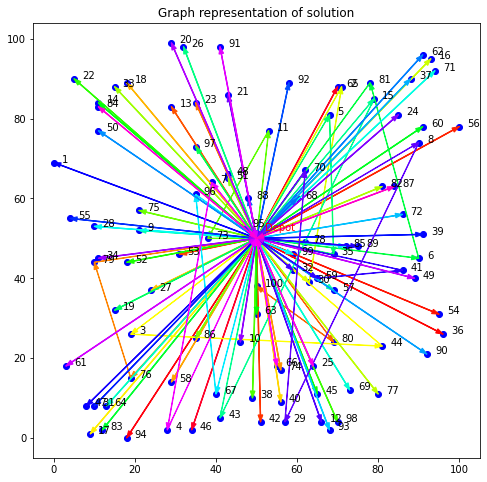

In [3]:
N = problem.neighborhood()
init_sol = N.initial_solution()
print('cost of initial solution =', init_sol.cost())
init_sol.plot_graph(figsize=8)

# Multi-Agent System Lab

### Utils

In [4]:
def dirr(obj):
    L = dir(obj)
    return list(filter(lambda method: not method.startswith('__'), L))

def epsilon_list(it, decay_rate = 0.99, epsilon=1):
    L=[]
    for i in range(it):
        L.append(epsilon)
        epsilon *= decay_rate
    return L

def get_decay_rate(N, percentage, tolerance=0.4):
    n_bar = int(N*percentage)
    try:
        gamma = tolerance**(1/n_bar)
    except:
        gamma = 0
    finally:
        return gamma
    
def plot_epsilon(seq):
    X = range(len(seq))
#     plt.plot(X,seq,'*r')
    plt.plot(X,seq,'-r')
    plt.xlabel('nb iterations')
    plt.ylabel('epsilon')
    plt.title('Decay_rate visualization')
    plt.show()
    return

## Automatic Decay Rate 

decay_rate = 0.9994245193792801


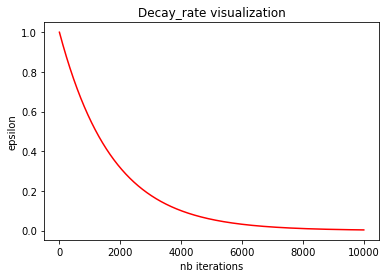

In [5]:
MAX_ITER = 10000
gamma = get_decay_rate(MAX_ITER, percentage=0.8, tolerance=0.01)
print('decay_rate =',gamma)
L = epsilon_list(MAX_ITER,decay_rate=gamma)
plot_epsilon(L)

## Agent Factory

In [6]:
agent_factory = AgentFactory()

BASIC_AGENT = agent_factory()
RS_AGENT = agent_factory(routine=SimulatedAnnealingRoutine)
TS_AGENT = agent_factory(routine=TabuRoutine)
GA_AGENT = agent_factory(routine=GeneticRoutine)
q_learning_params = {'gamma': gamma}

Q_AGENT = agent_factory(reinforced_learning=NeighborhoodQLearning, features_params={'reinforced_learning': q_learning_params})
RS_Q_AGENT = agent_factory(routine=SimulatedAnnealingRoutine, reinforced_learning=NeighborhoodQLearning,
                           features_params={'reinforced_learning': q_learning_params})
TS_Q_AGENT = agent_factory(routine=TabuRoutine, reinforced_learning=NeighborhoodQLearning,
                           features_params={'reinforced_learning': q_learning_params})
GA_Q_AGENT = agent_factory(routine=GeneticRoutine, reinforced_learning=NeighborhoodQLearning)

RS_COMPETITIVE = agent_factory(routine=SimulatedAnnealingRoutine,
                               reinforced_learning=NeighborhoodQLearning,
                               desires = Competition,
                               features_params={'reinforced_learning': q_learning_params})
RS_DIVER = agent_factory(routine=SimulatedAnnealingRoutine,
                               reinforced_learning=NeighborhoodQLearning,
                               desires = Diversification,
                               features_params={'reinforced_learning': q_learning_params})

In [7]:
agents = {RS_AGENT: 0,
          TS_AGENT: 0,
          GA_AGENT: 3,
          RS_Q_AGENT: 0,
          TS_Q_AGENT: 0,
          GA_Q_AGENT: 0,
          RS_COMPETITIVE: 0,
          RS_DIVER: 0}
    
pools = [BestScorePool]

In [8]:
mas = MultiAgentSystem(model=SequentialModel,
                       agents=agents,
                       max_iter=MAX_ITER,
                       pools=pools,
                       display_pool=0,
                       progress_bar=True,
                       verbose=0)
mas.fit(problem)
mas_sol = mas.search()

Agents working...: 100%|██████████| 10000/10000 [16:38<00:00, 10.01it/s]


In [9]:
mas_sol.cost()

8458.305488567978

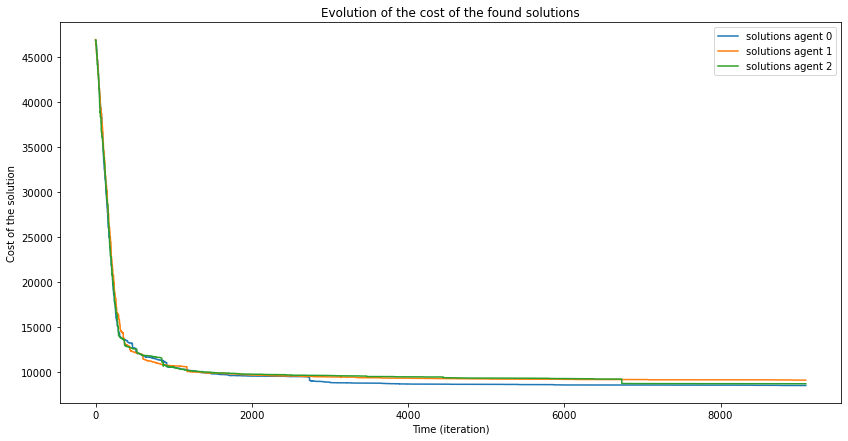

In [10]:
mas.plot_agents_cost()

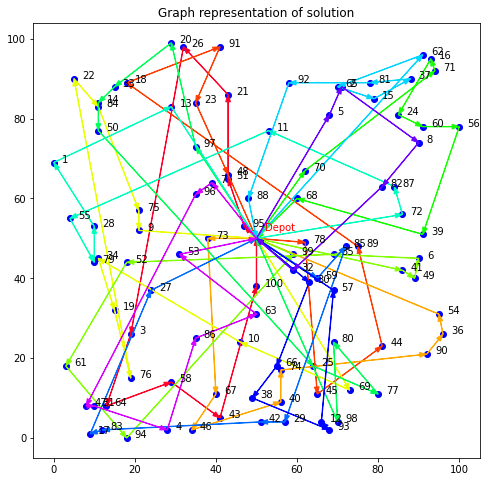

In [25]:
mas_sol.plot_graph()

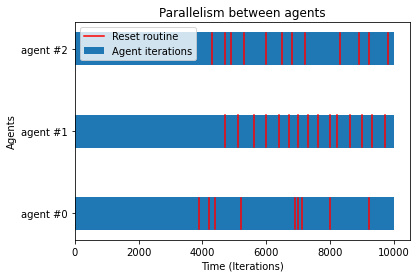

In [26]:
mas.plot_agent_parallelism()

In [27]:
AGENT_NUM = 0
agent = mas.get_agents()[AGENT_NUM]

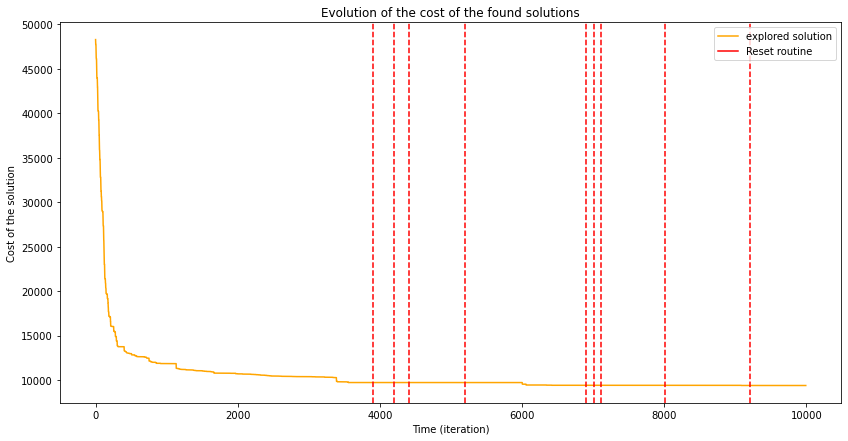

In [28]:
agent.plot_evolution_cost(resets=True)

In [29]:
agent.rl.display()

,intra_route_swap,inter_route_swap,intra_route_shift,inter_route_shift,two_intra_route_swap,two_intra_route_shift,delete_smallest_route,delete_random_route
intra_route_swap,45173.889683,43675.485784,42750.631162,43405.262356,34958.004227,41573.853029,47362.067904,45550.730680
inter_route_swap,45354.328441,43392.344616,43983.381971,43072.144950,40397.897102,44684.356017,45117.894906,46693.354748
intra_route_shift,47180.023198,45831.726026,45083.968507,43488.025914,40366.710873,40409.255437,42777.777982,40892.897700
inter_route_shift,43828.838368,43984.927051,42293.359742,43307.942388,46579.850440,45068.167406,41006.955542,44099.306033
two_intra_route_swap,46848.769072,40787.416287,40106.341039,43328.379952,40046.486161,43964.829252,42359.195406,42665.044654
two_intra_route_shift,43049.785988,42580.813368,47212.472469,43003.339318,42322.660891,45295.665893,40918.774169,44425.808151
delete_smallest_route,45861.984726,45273.871880,46339.160810,46438.382011,45431.523993,46282.149841,47219.458932,46847.829601
delete_random_route,41012.626280,42393.139363,42681.012844,43193.987428,43191.759510,47002.011413,44813.201285,44311.190983


In [30]:
agent.rl.display_info()

Q Learning Params
alpha = 0.1
gamma = 0.9994245193792801
epsilon = 0.0031787033528269323
Q-learning of choice of neighborhood structure sequences
states: ['intra_route_swap', 'inter_route_swap', 'intra_route_shift', 'inter_route_shift', 'two_intra_route_swap', 'two_intra_route_shift', 'delete_smallest_route', 'delete_random_route']
actions: ['intra_route_swap', 'inter_route_swap', 'intra_route_shift', 'inter_route_shift', 'two_intra_route_swap', 'two_intra_route_shift', 'delete_smallest_route', 'delete_random_route']
